<a href="https://colab.research.google.com/github/agarr3/vajra-new-2/blob/main/AE_HYBRID_GURBANI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from tqdm import tqdm_notebook as tqdm
from sklearn.preprocessing import LabelEncoder
from PIL import Image
import matplotlib.pyplot as plt
import torch
# Neural networks can be constructed using the torch.nn package.
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset
import torchvision
import torchvision.transforms as transforms

import IPython.display as ipd

import random

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#settings
batch_size = 64
validation_split = .3
shuffle_dataset = True
random_seed= 42
reduction_loss = "mean"
if reduction_loss == "mean":
  criterion = nn.MSELoss(reduction="mean")
elif reduction_loss == "sum":
  criterion = nn.MSELoss(reduction="sum")
n_epochs = 30
print_every = 1



DATA_BASE_PATH = "/content/gdrive/My Drive/vajra/AE_HYBRID_COMBINED/"
DATA_SONG_DIR = "originals"
DATA_IMG_DIR = "originals"
input_bins = 48
BASE_PATH = "/content/gdrive/My Drive/vajra/AE_HYBRID_GURBANI/"



seq_len=200
AE_encoded_dim = 64

class_level_loss_mode = "test"

print(device)

cuda:0


In [3]:
from google.colab import drive
drive._mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
print(os.path.join(DATA_BASE_PATH, DATA_IMG_DIR, "Western_numpy"))
             
train_files = []
exclusion = ["098567.npy","098569.npy", '098565.npy']
for r,d, fileList in os.walk(os.path.join(DATA_BASE_PATH, DATA_IMG_DIR, "training", "Western_numpy")):
  for file in fileList:
    if(file not in exclusion):
      train_files.append([file,file, "Western_numpy"])
    else:
      print(file)



for r,d, fileList in os.walk(os.path.join(DATA_BASE_PATH, DATA_IMG_DIR, "training", "Indian_numpy")):
  for file in fileList:
    if(True):
      train_files.append([file,file, "Indian_numpy"])
    else:
      print(file)

train_data = pd.DataFrame(train_files, columns=['Images','songs','labels'])
train_data.head()

/content/gdrive/My Drive/vajra/AE_HYBRID_COMBINED/originals/Western_numpy


,Images,songs,labels
0,western_147022_mel_1.npy,western_147022_mel_1.npy,Western_numpy
1,western_040182_mel_0.npy,western_040182_mel_0.npy,Western_numpy
2,western_133942_mel_0.npy,western_133942_mel_0.npy,Western_numpy
3,western_024912_mel_0.npy,western_024912_mel_0.npy,Western_numpy
4,western_130369_mel_1.npy,western_130369_mel_1.npy,Western_numpy


In [5]:
test_files = []
exclusion = ["098567.npy","098569.npy", '098565.npy']
for r,d, fileList in os.walk(os.path.join(DATA_BASE_PATH, DATA_IMG_DIR, "test", "Western_numpy")):
  for file in fileList:
    if(file not in exclusion):
      test_files.append([file,file, "Western_numpy"])
    else:
      print(file)

random.seed(1234)
test_files = random.sample(test_files, len(test_files))

for r,d, fileList in os.walk(os.path.join(DATA_BASE_PATH, DATA_IMG_DIR, "test", "Indian_numpy")):
  for file in fileList:
    if(True):
      test_files.append([file,file, "Indian_numpy"])
    else:
      print(file)

test_data = pd.DataFrame(test_files, columns=['Images','songs','labels'])
test_data.head()

,Images,songs,labels
0,western_130993_mel_0.npy,western_130993_mel_0.npy,Western_numpy
1,western_120189_mel_1.npy,western_120189_mel_1.npy,Western_numpy
2,western_111579_mel_1.npy,western_111579_mel_1.npy,Western_numpy
3,western_111793_mel_1.npy,western_111793_mel_1.npy,Western_numpy
4,western_122503_mel_1.npy,western_122503_mel_1.npy,Western_numpy


In [6]:
EXT_DATA_BASE_PATH = "/content/gdrive/My Drive/vajra/songs-vajra-data/MEL/48Bins"
EXT_DATA_SONG_DIR = "Chunked"
EXT_DATA_IMG_DIR = "Chunked"

gt_files = []
exclusion = ["098567.npy","098569.npy", '098565.npy']
for r,d, fileList in os.walk(os.path.join(EXT_DATA_BASE_PATH, EXT_DATA_IMG_DIR, "GurbaniMel")):
  for file in fileList:
    if(file not in exclusion):
      gt_files.append([os.path.join( r,file), file, "Indian_numpy"])
    else:
      print(file)

random.seed(1234)
gt_files = random.sample(gt_files, len(gt_files))

gt_data = pd.DataFrame(gt_files, columns=['path', 'fileName', 'labels'])
gt_data.head()

,path,fileName,labels
0,/content/gdrive/My Drive/vajra/songs-vajra-dat...,Bhai Arvinderpal Singh - Mayra_mel_36.npy,Indian_numpy
1,/content/gdrive/My Drive/vajra/songs-vajra-dat...,Jaspinder Narula - Tu Sultan K_mel_17.npy,Indian_numpy
2,/content/gdrive/My Drive/vajra/songs-vajra-dat...,01-Rabba-Lakh-Shukar-Manaawa_mel_63.npy,Indian_numpy
3,/content/gdrive/My Drive/vajra/songs-vajra-dat...,04 Swaranjit Kaur Neel - Mat D_mel_39.npy,Indian_numpy
4,/content/gdrive/My Drive/vajra/songs-vajra-dat...,Bhai Nirmal Singh - _mel_44.npy,Indian_numpy


In [7]:
train_data.groupby("labels").count()

,Images,songs
labels,,
Indian_numpy,2811,2811
Western_numpy,2800,2800


In [8]:
test_data.groupby("labels").count()

,Images,songs
labels,,
Indian_numpy,1205,1205
Western_numpy,1200,1200


In [9]:
gt_data.groupby("labels").count()

,path,fileName
labels,,
Indian_numpy,2651,2651


/content/gdrive/My Drive/vajra/AE_HYBRID_COMBINED/originals/test/Western_numpy/western_114223_mel_0.npy
80.0


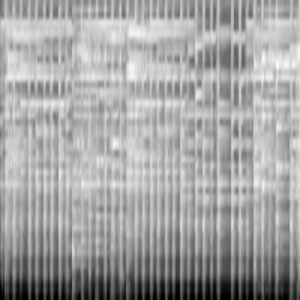

In [10]:
test_idx = random. randint(0,1000)
test_img_path = os.path.join(DATA_BASE_PATH, DATA_IMG_DIR, "test", test_data.loc[test_idx, 'labels'], test_data.loc[test_idx, 'Images'])
print(test_img_path)

numpy_arr = np.load(test_img_path)

array = numpy_arr*-1
print(array.max())
array *= (255.0/array.max())
array = 255 - array

test_image = Image.fromarray(array)
test_image = test_image.convert('L')
test_image = test_image.resize((300,300))
test_image



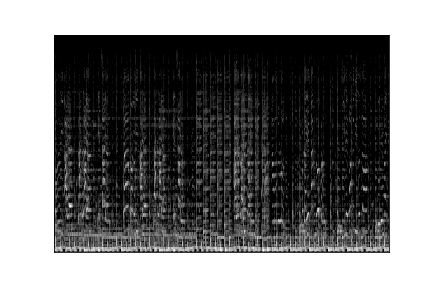

In [11]:
test_img_path = '/content/gdrive/My Drive/Kaggle/GTZAN/Data/images_original/reggae/reggae00016.png'
test_image = Image.open(test_img_path)
test_image = test_image.convert('RGB').convert('L')
test_image

In [12]:
lb = LabelEncoder()
train_data['encoded_labels'] = lb.fit_transform(train_data['labels'])
train_data.head()

,Images,songs,labels,encoded_labels
0,western_147022_mel_1.npy,western_147022_mel_1.npy,Western_numpy,1
1,western_040182_mel_0.npy,western_040182_mel_0.npy,Western_numpy,1
2,western_133942_mel_0.npy,western_133942_mel_0.npy,Western_numpy,1
3,western_024912_mel_0.npy,western_024912_mel_0.npy,Western_numpy,1
4,western_130369_mel_1.npy,western_130369_mel_1.npy,Western_numpy,1


In [13]:
test_data['encoded_labels'] = lb.transform(test_data['labels'])
test_data.head()

,Images,songs,labels,encoded_labels
0,western_130993_mel_0.npy,western_130993_mel_0.npy,Western_numpy,1
1,western_120189_mel_1.npy,western_120189_mel_1.npy,Western_numpy,1
2,western_111579_mel_1.npy,western_111579_mel_1.npy,Western_numpy,1
3,western_111793_mel_1.npy,western_111793_mel_1.npy,Western_numpy,1
4,western_122503_mel_1.npy,western_122503_mel_1.npy,Western_numpy,1


In [14]:
gt_data['encoded_labels'] = lb.transform(gt_data['labels'])
gt_data.head()

,path,fileName,labels,encoded_labels
0,/content/gdrive/My Drive/vajra/songs-vajra-dat...,Bhai Arvinderpal Singh - Mayra_mel_36.npy,Indian_numpy,0
1,/content/gdrive/My Drive/vajra/songs-vajra-dat...,Jaspinder Narula - Tu Sultan K_mel_17.npy,Indian_numpy,0
2,/content/gdrive/My Drive/vajra/songs-vajra-dat...,01-Rabba-Lakh-Shukar-Manaawa_mel_63.npy,Indian_numpy,0
3,/content/gdrive/My Drive/vajra/songs-vajra-dat...,04 Swaranjit Kaur Neel - Mat D_mel_39.npy,Indian_numpy,0
4,/content/gdrive/My Drive/vajra/songs-vajra-dat...,Bhai Nirmal Singh - _mel_44.npy,Indian_numpy,0


In [15]:
classes = ('Indian_numpy', 'Western_numpy')
train_data.groupby(by=['labels','encoded_labels']).count()

,,Images,songs
labels,encoded_labels,,
Indian_numpy,0,2811,2811
Western_numpy,1,2800,2800


In [16]:
test_data.groupby(by=['labels','encoded_labels']).count()

,,Images,songs
labels,encoded_labels,,
Indian_numpy,0,1205,1205
Western_numpy,1,1200,1200


In [17]:
gt_data.groupby(by=['labels','encoded_labels']).count()

,,path,fileName
labels,encoded_labels,,
Indian_numpy,0,2651,2651


In [18]:
from sklearn.model_selection import train_test_split

train_data_combined = train_data.copy(deep=True)
test_data_combined = test_data.copy(deep=True)

# train_data = train_data[train_data['labels'] == "Western_numpy"]
# test_data = test_data[test_data['labels'] == "Western_numpy"]


df_train, df_test = train_test_split(gt_data, test_size=validation_split, stratify=gt_data[["labels"]])

df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)


In [19]:
df_train.groupby(by=['labels','encoded_labels']).count()

,,path,fileName
labels,encoded_labels,,
Indian_numpy,0,1855,1855


In [20]:
df_test.groupby(by=['labels','encoded_labels']).count()

,,path,fileName
labels,encoded_labels,,
Indian_numpy,0,796,796


In [21]:
transform_normal = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

transform = transforms.Compose(
    [transforms.ToTensor()])

In [22]:
class MEL_Dataset(Dataset):
    def __init__(self, img_data,img_path,transform=None):
        self.img_path = img_path
        self.transform = transform
        self.img_data = img_data
        
    def __len__(self):
        return len(self.img_data)
    
    def __getitem__(self, index):
        img_name = os.path.join(self.img_path,self.img_data.loc[index, 'labels'],
                                self.img_data.loc[index, 'Images'])
        image = np.load(img_name)
        data = torch.tensor(image[:,:seq_len], dtype=torch.float)
        data = data.permute(1, 0)
        label = torch.tensor(self.img_data.loc[index, 'encoded_labels'])
        fileName = self.img_data.loc[index, 'Images']
        return data, label, fileName



In [23]:
class MEL_Dataset_EXT(Dataset):
    def __init__(self, img_data,transform=None):
        self.transform = transform
        self.img_data = img_data
        
    def __len__(self):
        return len(self.img_data)
    
    def __getitem__(self, index):
        img_name = self.img_data.loc[index, 'path']
        image = np.load(img_name)
        data = torch.tensor(image[:,:seq_len], dtype=torch.float)
        data = data.permute(1, 0)
        label = torch.tensor(self.img_data.loc[index, 'encoded_labels'])
        
        fileName = self.img_data.loc[index, 'fileName']
        return data, label, fileName

In [24]:
train_dataset = MEL_Dataset_EXT(df_train,transform)
test_dataset = MEL_Dataset_EXT(df_test,transform)

train_dataset_combined = MEL_Dataset(train_data_combined,os.path.join(DATA_BASE_PATH, DATA_IMG_DIR, "training"),transform)
test_dataset_combined = MEL_Dataset(test_data_combined,os.path.join(DATA_BASE_PATH, DATA_IMG_DIR, "test"),transform)

In [25]:
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

trainloader_combined = torch.utils.data.DataLoader(train_dataset_combined, batch_size=batch_size)
testloader_combined = torch.utils.data.DataLoader(test_dataset_combined, batch_size=batch_size)

In [26]:
def mel_display(S_DB):
    S_DB = S_DB.numpy()
    array = S_DB*-1
    array *= (255.0/array.max())
    #array = 255 - array
    array = np.transpose(array, (2, 1, 0))
    return array.squeeze()

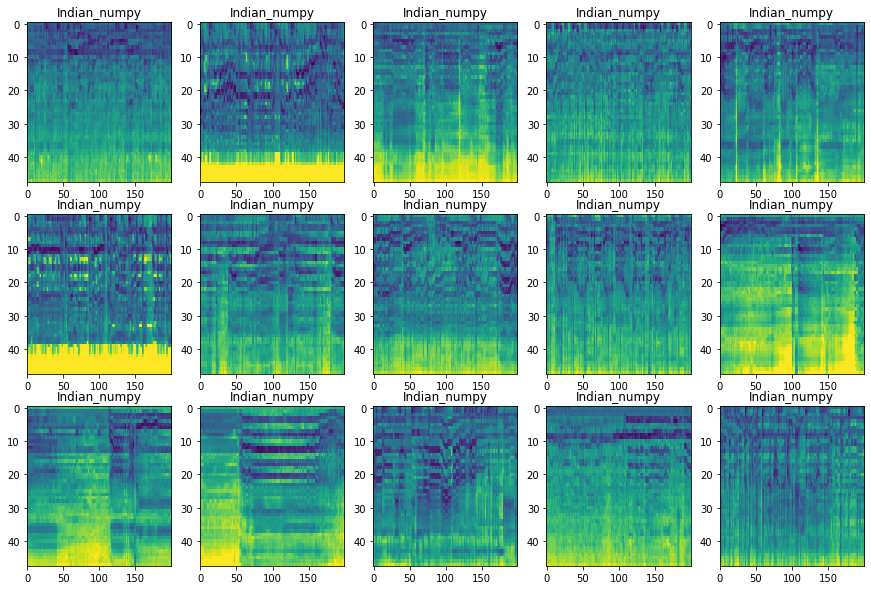

In [27]:
# get some random training images
dataiter = iter(trainloader)
images, labels, fileNames = dataiter.next()
arthopod_types = {0: 'Indian_numpy', 1: 'Western_numpy', 2: 'country', 3: 'disco', 4: 'hiphop', 5: 'jazz', 6: 'metal', 7: 'pop', 8: 'reggae', 9: 'rock'}
# Viewing data examples used for training
fig, axis = plt.subplots(3, 5, figsize=(15, 10))
for i, ax in enumerate(axis.flat):
    with torch.no_grad():
        image, label = images[i], labels[i]
        ax.imshow(mel_display(image.unsqueeze(dim=0)), interpolation='nearest', aspect='auto') # add image
        ax.set(title = f"{arthopod_types[label.item()]}") # add label

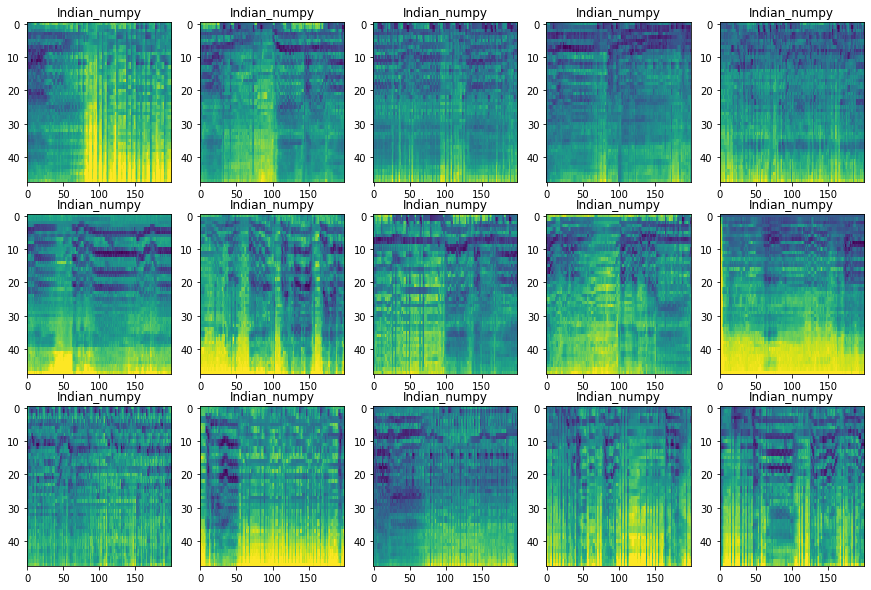

In [28]:
# get some random training images
dataiter = iter(testloader)
images, labels, fileNames = dataiter.next()
arthopod_types = {0: 'Indian_numpy', 1: 'Western_numpy', 2: 'country', 3: 'disco', 4: 'hiphop', 5: 'jazz', 6: 'metal', 7: 'pop', 8: 'reggae', 9: 'rock'}
# Viewing data examples used for training
fig, axis = plt.subplots(3, 5, figsize=(15, 10))
for i, ax in enumerate(axis.flat):
    with torch.no_grad():
        image, label = images[i], labels[i]
        ax.imshow(mel_display(image.unsqueeze(dim=0)), interpolation='nearest', aspect='auto') # add image
        ax.set(title = f"{arthopod_types[label.item()]}") # add label

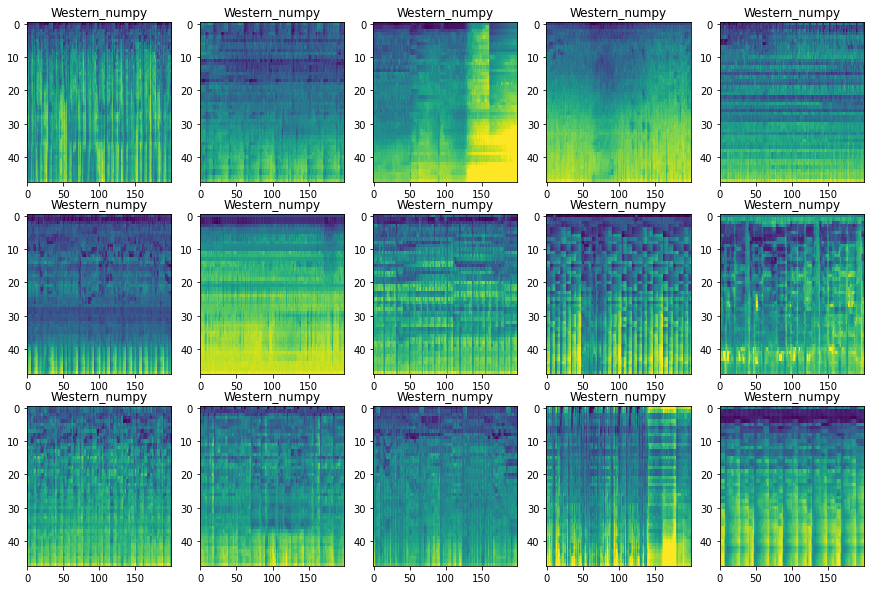

In [29]:
# get some random training images
dataiter = iter(trainloader_combined)
images, labels, fileNames = dataiter.next()
arthopod_types = {0: 'Indian_numpy', 1: 'Western_numpy', 2: 'country', 3: 'disco', 4: 'hiphop', 5: 'jazz', 6: 'metal', 7: 'pop', 8: 'reggae', 9: 'rock'}
# Viewing data examples used for training
fig, axis = plt.subplots(3, 5, figsize=(15, 10))
for i, ax in enumerate(axis.flat):
    with torch.no_grad():
        image, label = images[i], labels[i]
        ax.imshow(mel_display(image.unsqueeze(dim=0)), interpolation='nearest', aspect='auto') # add image
        ax.set(title = f"{arthopod_types[label.item()]}") # add label

In [30]:
class Encoder(torch.nn.Module):
  def __init__(self, seq_len, n_features, embedding_dim=64, kernel_size=[4,3,2], stride=[1,1,1]):
    super(Encoder, self).__init__()
    self.seq_len, self.n_features = seq_len, n_features
    self.embedding_dim, self.hidden_dim = embedding_dim, 2 * embedding_dim


    self.conv = nn.Conv1d(in_channels=seq_len,out_channels=seq_len,kernel_size=kernel_size[0],stride=stride[0], groups=seq_len)
    conv_op_dim = int(((n_features - kernel_size[0])/ stride[0]) + 1)

    self.conv_1 = nn.Conv1d(in_channels=seq_len,out_channels=seq_len,kernel_size=kernel_size[1],stride=stride[1], groups=seq_len)
    conv_op_dim1 = int(((conv_op_dim - kernel_size[1])/ stride[1]) + 1)

    self.conv_2 = nn.Conv1d(in_channels=seq_len,out_channels=seq_len,kernel_size=kernel_size[2],stride=stride[2], groups=seq_len)
    conv_op_dim2 = int(((conv_op_dim1 - kernel_size[2])/ stride[2]) + 1)

    self.rnn1 = nn.LSTM(
      input_size=conv_op_dim2,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )
    self.rnn2 = nn.LSTM(
      input_size=self.hidden_dim,
      hidden_size=embedding_dim,
      num_layers=1,
      batch_first=True
    )
  def forward(self, x):
    x = self.conv(x)
    x = self.conv_1(x)
    x = self.conv_2(x)
    lstm_l1_op, (_, _) = self.rnn1(x)
    lstm_l2_op, (hidden_n, _) = self.rnn2(lstm_l1_op)
    return lstm_l2_op, lstm_l1_op

class Decoder(torch.nn.Module):
  def __init__(self, seq_len, embedding_dim=64, n_features=26):
    super(Decoder, self).__init__()
    self.seq_len, self.embedding_dim = seq_len, embedding_dim
    self.hidden_dim, self.n_features = 2 * embedding_dim, n_features
    self.rnn1 = nn.LSTM(
      input_size=embedding_dim,
      hidden_size=embedding_dim,
      num_layers=1,
      batch_first=True
    )
    self.rnn2 = nn.LSTM(
      input_size=embedding_dim,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )
    self.output_layer = nn.Linear(self.hidden_dim * self.seq_len, n_features * self.seq_len)
  def forward(self, x):
    x, (hidden_n, cell_n) = self.rnn1(x)
    x, (hidden_n, cell_n) = self.rnn2(x)
    x = x.contiguous()
    x = x.view(x.shape[0], -1)
    x = self.output_layer(x)
    return x.reshape(x.shape[0],self.seq_len, self.n_features)

class RecurrentAutoencoder(torch.nn.Module):
  def __init__(self, seq_len, n_features, embedding_dim=64, device='cpu'):
    super(RecurrentAutoencoder, self).__init__()
    self.encoder = Encoder(seq_len, n_features, embedding_dim).to(device)
    self.decoder = Decoder(seq_len, embedding_dim, n_features).to(device)
  def forward(self, x):
    x, l1_op = self.encoder(x)
    x = self.decoder(x)
    return x

net = RecurrentAutoencoder(seq_len, input_bins, AE_encoded_dim, device=device)
net.to(device)


RecurrentAutoencoder(
  (encoder): Encoder(
    (conv): Conv1d(200, 200, kernel_size=(4,), stride=(1,), groups=200)
    (conv_1): Conv1d(200, 200, kernel_size=(3,), stride=(1,), groups=200)
    (conv_2): Conv1d(200, 200, kernel_size=(2,), stride=(1,), groups=200)
    (rnn1): LSTM(42, 128, batch_first=True)
    (rnn2): LSTM(128, 64, batch_first=True)
  )
  (decoder): Decoder(
    (rnn1): LSTM(64, 64, batch_first=True)
    (rnn2): LSTM(64, 128, batch_first=True)
    (output_layer): Linear(in_features=25600, out_features=9600, bias=True)
  )
)

In [31]:
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

In [32]:
import matplotlib.pyplot as plt
import numpy as np

def visualize(train_loss_graph, test_loss_graph):
  x = range(len(train_loss_graph))
      
  # plot lines
  plt.plot(x, train_loss_graph, label = "Training Loss")
  plt.plot(x, test_loss_graph, label = "Test Loss")
  
  plt.legend()
  plt.show()


def visualize_class_loss(in_loss_graph, we_loss_graph):
  x = range(len(in_loss_graph))
      
  # plot lines
  plt.plot(x, in_loss_graph, label = "Indian Loss")
  plt.plot(x, we_loss_graph, label = "Western Loss")
  
  plt.legend()
  plt.show()


[1,     1] loss: 1927.017
[1,     2] loss: 1672.867
[1,     3] loss: 1738.523
[1,     4] loss: 1725.049
[1,     5] loss: 1525.167
[1,     6] loss: 1197.194
[1,     7] loss: 1024.105
[1,     8] loss: 640.663
[1,     9] loss: 290.648
[1,    10] loss: 548.529
[1,    11] loss: 426.565
[1,    12] loss: 200.401
[1,    13] loss: 133.348
[1,    14] loss: 206.348
[1,    15] loss: 211.314
[1,    16] loss: 193.570
[1,    17] loss: 219.173
[1,    18] loss: 196.854
[1,    19] loss: 139.823
[1,    20] loss: 138.181
[1,    21] loss: 147.986
[1,    22] loss: 149.042
[1,    23] loss: 172.031
[1,    24] loss: 190.233
[1,    25] loss: 181.675
[1,    26] loss: 157.126
[1,    27] loss: 139.591
[1,    28] loss: 151.809
[1,    29] loss: 151.165
LOSS of the network on the train images after epoch 0 is 15795.995895385742
Mean of the network on the train images after epoch 0 is 564.1427105494907
LOSS of the network on the test images: 1731 %
Mean of the network on the train images after epoch 0 is 144.272761027

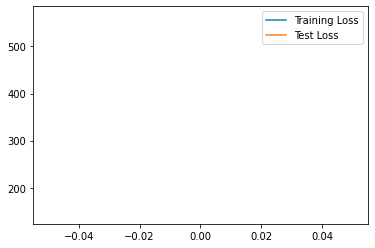

[2,     1] loss: 115.261
[2,     2] loss: 123.420
[2,     3] loss: 123.938
[2,     4] loss: 161.857
[2,     5] loss: 136.893
[2,     6] loss: 103.656
[2,     7] loss: 150.760
[2,     8] loss: 127.882
[2,     9] loss: 132.308
[2,    10] loss: 119.322
[2,    11] loss: 133.203
[2,    12] loss: 133.363
[2,    13] loss: 116.569
[2,    14] loss: 140.098
[2,    15] loss: 127.323
[2,    16] loss: 120.368
[2,    17] loss: 133.328
[2,    18] loss: 122.008
[2,    19] loss: 110.248
[2,    20] loss: 121.964
[2,    21] loss: 129.860
[2,    22] loss: 119.743
[2,    23] loss: 124.492
[2,    24] loss: 138.400
[2,    25] loss: 130.327
[2,    26] loss: 113.947
[2,    27] loss: 123.704
[2,    28] loss: 137.866
[2,    29] loss: 145.168
LOSS of the network on the train images after epoch 1 is 3717.27685546875
Mean of the network on the train images after epoch 1 is 132.7598876953125
LOSS of the network on the test images: 1672 %
Mean of the network on the train images after epoch 1 is 139.3908602396647


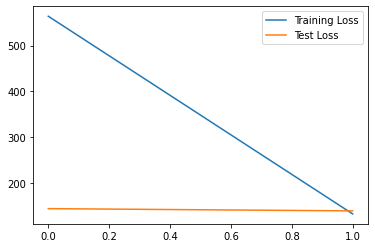

[3,     1] loss: 109.220
[3,     2] loss: 132.057
[3,     3] loss: 115.167
[3,     4] loss: 146.428
[3,     5] loss: 125.111
[3,     6] loss: 100.312
[3,     7] loss: 142.772
[3,     8] loss: 120.857
[3,     9] loss: 124.299
[3,    10] loss: 107.531
[3,    11] loss: 119.868
[3,    12] loss: 121.672
[3,    13] loss: 107.224
[3,    14] loss: 128.745
[3,    15] loss: 117.448
[3,    16] loss: 113.629
[3,    17] loss: 121.962
[3,    18] loss: 114.169
[3,    19] loss: 103.727
[3,    20] loss: 113.692
[3,    21] loss: 117.259
[3,    22] loss: 106.993
[3,    23] loss: 112.237
[3,    24] loss: 123.063
[3,    25] loss: 109.230
[3,    26] loss: 99.390
[3,    27] loss: 106.544
[3,    28] loss: 116.551
[3,    29] loss: 123.739
LOSS of the network on the train images after epoch 2 is 3400.8960876464844
Mean of the network on the train images after epoch 2 is 121.46057455880302
LOSS of the network on the test images: 1310 %
Mean of the network on the train images after epoch 2 is 109.19773356119792


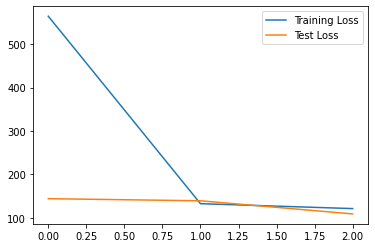

[4,     1] loss: 93.042
[4,     2] loss: 104.460
[4,     3] loss: 99.756
[4,     4] loss: 123.192
[4,     5] loss: 110.155
[4,     6] loss: 81.527
[4,     7] loss: 113.928
[4,     8] loss: 98.074
[4,     9] loss: 98.781
[4,    10] loss: 98.894
[4,    11] loss: 96.447
[4,    12] loss: 100.571
[4,    13] loss: 92.926
[4,    14] loss: 98.527
[4,    15] loss: 92.089
[4,    16] loss: 101.507
[4,    17] loss: 93.876
[4,    18] loss: 97.361
[4,    19] loss: 89.859
[4,    20] loss: 93.939
[4,    21] loss: 97.663
[4,    22] loss: 90.684
[4,    23] loss: 91.520
[4,    24] loss: 106.132
[4,    25] loss: 84.951
[4,    26] loss: 86.167
[4,    27] loss: 90.672
[4,    28] loss: 99.562
[4,    29] loss: 97.462
LOSS of the network on the train images after epoch 3 is 2823.7237396240234
Mean of the network on the train images after epoch 3 is 100.8472764151437
LOSS of the network on the test images: 1167 %
Mean of the network on the train images after epoch 3 is 97.29689915974934


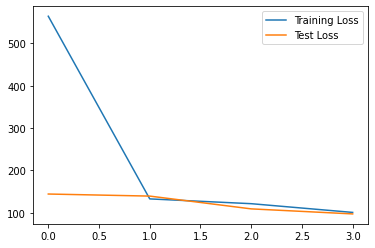

[5,     1] loss: 81.442
[5,     2] loss: 83.811
[5,     3] loss: 87.054
[5,     4] loss: 107.427
[5,     5] loss: 88.550
[5,     6] loss: 76.259
[5,     7] loss: 91.298
[5,     8] loss: 86.082
[5,     9] loss: 93.180
[5,    10] loss: 82.706
[5,    11] loss: 90.054
[5,    12] loss: 94.914
[5,    13] loss: 81.593
[5,    14] loss: 90.714
[5,    15] loss: 85.959
[5,    16] loss: 91.513
[5,    17] loss: 89.538
[5,    18] loss: 90.362
[5,    19] loss: 84.807
[5,    20] loss: 90.291
[5,    21] loss: 93.988
[5,    22] loss: 85.868
[5,    23] loss: 89.318
[5,    24] loss: 100.694
[5,    25] loss: 82.021
[5,    26] loss: 84.239
[5,    27] loss: 84.552
[5,    28] loss: 96.607
[5,    29] loss: 94.805
LOSS of the network on the train images after epoch 4 is 2579.645347595215
Mean of the network on the train images after epoch 4 is 92.1301909855434
LOSS of the network on the test images: 1140 %
Mean of the network on the train images after epoch 4 is 95.05377578735352


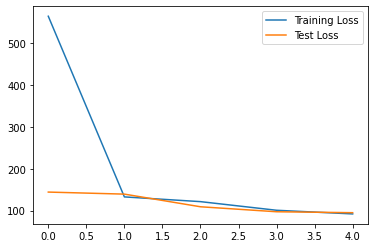

[6,     1] loss: 78.936
[6,     2] loss: 80.679
[6,     3] loss: 85.117
[6,     4] loss: 104.960
[6,     5] loss: 86.208
[6,     6] loss: 74.955
[6,     7] loss: 88.733
[6,     8] loss: 84.477
[6,     9] loss: 91.355
[6,    10] loss: 81.806
[6,    11] loss: 89.164
[6,    12] loss: 93.144
[6,    13] loss: 80.683
[6,    14] loss: 89.139
[6,    15] loss: 84.963
[6,    16] loss: 90.213
[6,    17] loss: 88.505
[6,    18] loss: 89.335
[6,    19] loss: 83.999
[6,    20] loss: 89.556
[6,    21] loss: 93.269
[6,    22] loss: 85.307
[6,    23] loss: 88.555
[6,    24] loss: 99.762
[6,    25] loss: 81.210
[6,    26] loss: 83.626
[6,    27] loss: 83.326
[6,    28] loss: 95.446
[6,    29] loss: 93.664
LOSS of the network on the train images after epoch 5 is 2540.094337463379
Mean of the network on the train images after epoch 5 is 90.71765490940639
LOSS of the network on the test images: 1128 %
Mean of the network on the train images after epoch 5 is 94.01679865519206


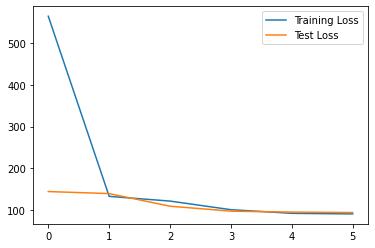

[7,     1] loss: 78.013
[7,     2] loss: 79.850
[7,     3] loss: 84.107
[7,     4] loss: 103.524
[7,     5] loss: 85.103
[7,     6] loss: 74.176
[7,     7] loss: 87.230
[7,     8] loss: 83.494
[7,     9] loss: 90.348
[7,    10] loss: 81.211
[7,    11] loss: 88.075
[7,    12] loss: 91.969
[7,    13] loss: 79.866
[7,    14] loss: 87.970
[7,    15] loss: 83.926
[7,    16] loss: 89.088
[7,    17] loss: 87.411
[7,    18] loss: 88.148
[7,    19] loss: 83.082
[7,    20] loss: 88.718
[7,    21] loss: 92.171
[7,    22] loss: 84.210
[7,    23] loss: 87.469
[7,    24] loss: 98.160
[7,    25] loss: 79.864
[7,    26] loss: 82.278
[7,    27] loss: 82.101
[7,    28] loss: 93.813
[7,    29] loss: 92.119
LOSS of the network on the train images after epoch 6 is 2507.4930267333984
Mean of the network on the train images after epoch 6 is 89.55332238333565
LOSS of the network on the test images: 1117 %
Mean of the network on the train images after epoch 6 is 93.14918963114421


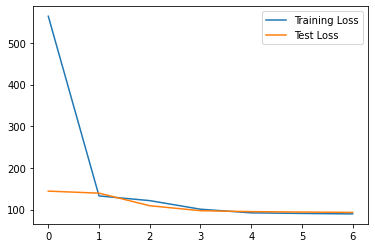

[8,     1] loss: 77.647
[8,     2] loss: 79.018
[8,     3] loss: 83.992
[8,     4] loss: 101.952
[8,     5] loss: 83.756
[8,     6] loss: 73.651
[8,     7] loss: 84.974
[8,     8] loss: 82.291
[8,     9] loss: 88.893
[8,    10] loss: 80.281
[8,    11] loss: 86.333
[8,    12] loss: 89.843
[8,    13] loss: 78.799
[8,    14] loss: 85.664
[8,    15] loss: 82.138
[8,    16] loss: 87.193
[8,    17] loss: 85.210
[8,    18] loss: 86.159
[8,    19] loss: 81.692
[8,    20] loss: 87.213
[8,    21] loss: 89.851
[8,    22] loss: 81.243
[8,    23] loss: 84.233
[8,    24] loss: 93.637
[8,    25] loss: 75.684
[8,    26] loss: 79.905
[8,    27] loss: 79.232
[8,    28] loss: 91.773
[8,    29] loss: 87.981
LOSS of the network on the train images after epoch 7 is 2450.238052368164
Mean of the network on the train images after epoch 7 is 87.50850187029157
LOSS of the network on the test images: 1084 %
Mean of the network on the train images after epoch 7 is 90.3931770324707


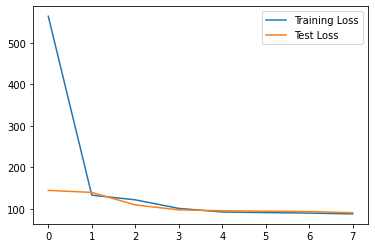

[9,     1] loss: 76.727
[9,     2] loss: 78.846
[9,     3] loss: 80.659
[9,     4] loss: 97.097
[9,     5] loss: 80.735
[9,     6] loss: 72.020
[9,     7] loss: 80.278
[9,     8] loss: 79.286
[9,     9] loss: 85.824
[9,    10] loss: 78.089
[9,    11] loss: 83.244
[9,    12] loss: 85.371
[9,    13] loss: 76.629
[9,    14] loss: 82.678
[9,    15] loss: 79.221
[9,    16] loss: 84.625
[9,    17] loss: 82.622
[9,    18] loss: 83.226
[9,    19] loss: 79.068
[9,    20] loss: 85.348
[9,    21] loss: 86.618
[9,    22] loss: 78.127
[9,    23] loss: 80.778
[9,    24] loss: 89.722
[9,    25] loss: 73.119
[9,    26] loss: 75.965
[9,    27] loss: 75.268
[9,    28] loss: 86.945
[9,    29] loss: 85.123
LOSS of the network on the train images after epoch 8 is 2363.257339477539
Mean of the network on the train images after epoch 8 is 84.40204783848354
LOSS of the network on the test images: 1046 %
Mean of the network on the train images after epoch 8 is 87.21531613667806


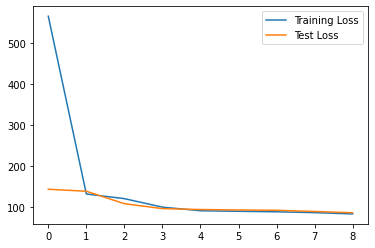

[10,     1] loss: 73.507
[10,     2] loss: 75.340
[10,     3] loss: 77.664
[10,     4] loss: 90.953
[10,     5] loss: 77.688
[10,     6] loss: 68.751
[10,     7] loss: 77.133
[10,     8] loss: 76.210
[10,     9] loss: 82.058
[10,    10] loss: 74.903
[10,    11] loss: 79.845
[10,    12] loss: 81.298
[10,    13] loss: 73.502
[10,    14] loss: 79.445
[10,    15] loss: 76.105
[10,    16] loss: 80.898
[10,    17] loss: 79.635
[10,    18] loss: 79.573
[10,    19] loss: 75.527
[10,    20] loss: 81.861
[10,    21] loss: 82.697
[10,    22] loss: 74.732
[10,    23] loss: 76.697
[10,    24] loss: 85.589
[10,    25] loss: 70.594
[10,    26] loss: 72.181
[10,    27] loss: 71.814
[10,    28] loss: 82.610
[10,    29] loss: 81.889
LOSS of the network on the train images after epoch 9 is 2260.70011138916
Mean of the network on the train images after epoch 9 is 80.73928969247001
LOSS of the network on the test images: 998 %
Mean of the network on the train images after epoch 9 is 83.18533198038737


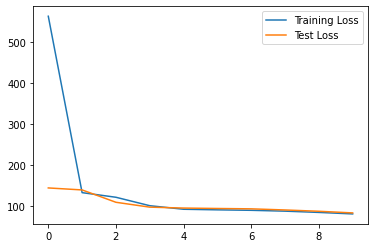

[11,     1] loss: 69.816
[11,     2] loss: 72.288
[11,     3] loss: 73.514
[11,     4] loss: 85.862
[11,     5] loss: 74.569
[11,     6] loss: 65.873
[11,     7] loss: 74.160
[11,     8] loss: 72.724
[11,     9] loss: 77.072
[11,    10] loss: 70.286
[11,    11] loss: 74.811
[11,    12] loss: 76.856
[11,    13] loss: 69.191
[11,    14] loss: 74.855
[11,    15] loss: 71.709
[11,    16] loss: 75.484
[11,    17] loss: 75.110
[11,    18] loss: 73.842
[11,    19] loss: 70.811
[11,    20] loss: 74.760
[11,    21] loss: 77.407
[11,    22] loss: 71.061
[11,    23] loss: 71.100
[11,    24] loss: 78.359
[11,    25] loss: 68.116
[11,    26] loss: 70.313
[11,    27] loss: 68.445
[11,    28] loss: 77.278
[11,    29] loss: 74.141
LOSS of the network on the train images after epoch 10 is 2129.8152923583984
Mean of the network on the train images after epoch 10 is 76.06483186994281
LOSS of the network on the test images: 941 %
Mean of the network on the train images after epoch 10 is 78.48276456197102


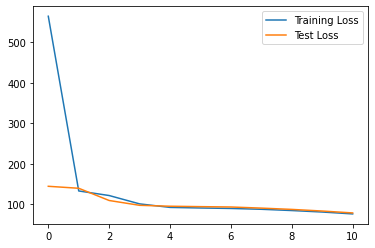

[12,     1] loss: 65.959
[12,     2] loss: 66.363
[12,     3] loss: 68.802
[12,     4] loss: 82.117
[12,     5] loss: 71.767
[12,     6] loss: 64.142
[12,     7] loss: 70.367
[12,     8] loss: 71.027
[12,     9] loss: 72.433
[12,    10] loss: 65.259
[12,    11] loss: 69.629
[12,    12] loss: 71.946
[12,    13] loss: 65.811
[12,    14] loss: 71.430
[12,    15] loss: 68.222
[12,    16] loss: 71.016
[12,    17] loss: 71.370
[12,    18] loss: 68.258
[12,    19] loss: 68.254
[12,    20] loss: 69.117
[12,    21] loss: 73.149
[12,    22] loss: 68.185
[12,    23] loss: 67.246
[12,    24] loss: 73.848
[12,    25] loss: 65.888
[12,    26] loss: 67.331
[12,    27] loss: 65.212
[12,    28] loss: 75.673
[12,    29] loss: 70.861
LOSS of the network on the train images after epoch 11 is 2020.6840362548828
Mean of the network on the train images after epoch 11 is 72.16728700910296
LOSS of the network on the test images: 894 %
Mean of the network on the train images after epoch 11 is 74.52472559611003


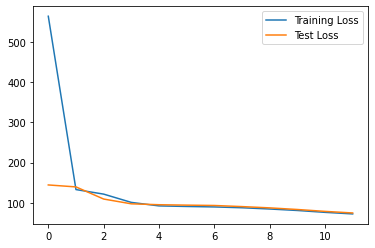

[13,     1] loss: 63.160
[13,     2] loss: 64.736
[13,     3] loss: 66.878
[13,     4] loss: 79.149
[13,     5] loss: 69.320
[13,     6] loss: 62.520
[13,     7] loss: 67.965
[13,     8] loss: 66.919
[13,     9] loss: 69.286
[13,    10] loss: 63.506
[13,    11] loss: 67.098
[13,    12] loss: 70.102
[13,    13] loss: 63.237
[13,    14] loss: 69.411
[13,    15] loss: 66.767
[13,    16] loss: 68.922
[13,    17] loss: 69.806
[13,    18] loss: 66.302
[13,    19] loss: 67.188
[13,    20] loss: 67.695
[13,    21] loss: 71.409
[13,    22] loss: 66.764
[13,    23] loss: 65.796
[13,    24] loss: 71.872
[13,    25] loss: 64.414
[13,    26] loss: 65.964
[13,    27] loss: 63.426
[13,    28] loss: 72.370
[13,    29] loss: 68.468
LOSS of the network on the train images after epoch 12 is 1960.450569152832
Mean of the network on the train images after epoch 12 is 70.01609175545829
LOSS of the network on the test images: 878 %
Mean of the network on the train images after epoch 12 is 73.21374893188477


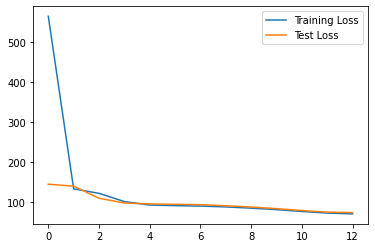

[14,     1] loss: 62.400
[14,     2] loss: 61.700
[14,     3] loss: 65.484
[14,     4] loss: 76.462
[14,     5] loss: 66.703
[14,     6] loss: 60.893
[14,     7] loss: 66.829
[14,     8] loss: 66.141
[14,     9] loss: 67.997
[14,    10] loss: 62.052
[14,    11] loss: 65.414
[14,    12] loss: 68.590
[14,    13] loss: 62.475
[14,    14] loss: 68.041
[14,    15] loss: 65.465
[14,    16] loss: 67.239
[14,    17] loss: 68.298
[14,    18] loss: 65.060
[14,    19] loss: 65.834
[14,    20] loss: 66.034
[14,    21] loss: 69.966
[14,    22] loss: 65.306
[14,    23] loss: 64.562
[14,    24] loss: 70.220
[14,    25] loss: 63.431
[14,    26] loss: 65.009
[14,    27] loss: 62.108
[14,    28] loss: 69.992
[14,    29] loss: 67.633
LOSS of the network on the train images after epoch 13 is 1917.3391227722168
Mean of the network on the train images after epoch 13 is 68.47639724186489
LOSS of the network on the test images: 874 %
Mean of the network on the train images after epoch 13 is 72.83833916982015


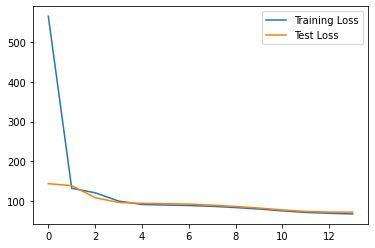

[15,     1] loss: 62.314
[15,     2] loss: 60.460
[15,     3] loss: 64.461
[15,     4] loss: 75.770
[15,     5] loss: 66.839
[15,     6] loss: 60.188
[15,     7] loss: 65.749
[15,     8] loss: 66.822
[15,     9] loss: 67.125
[15,    10] loss: 61.317
[15,    11] loss: 64.948
[15,    12] loss: 67.514
[15,    13] loss: 62.675
[15,    14] loss: 67.416
[15,    15] loss: 64.494
[15,    16] loss: 66.375
[15,    17] loss: 67.331
[15,    18] loss: 64.060
[15,    19] loss: 65.035
[15,    20] loss: 64.771
[15,    21] loss: 68.888
[15,    22] loss: 64.521
[15,    23] loss: 63.576
[15,    24] loss: 68.898
[15,    25] loss: 62.633
[15,    26] loss: 63.544
[15,    27] loss: 61.180
[15,    28] loss: 68.475
[15,    29] loss: 65.587
LOSS of the network on the train images after epoch 14 is 1892.966609954834
Mean of the network on the train images after epoch 14 is 67.60595035552979
LOSS of the network on the test images: 846 %
Mean of the network on the train images after epoch 14 is 70.54327456156413


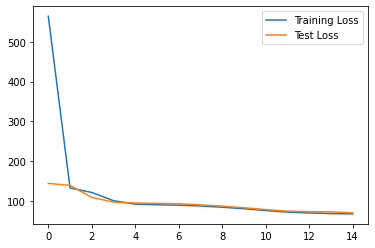

[16,     1] loss: 60.763
[16,     2] loss: 59.651
[16,     3] loss: 63.288
[16,     4] loss: 73.426
[16,     5] loss: 64.258
[16,     6] loss: 58.769
[16,     7] loss: 64.032
[16,     8] loss: 63.061
[16,     9] loss: 64.696
[16,    10] loss: 59.582
[16,    11] loss: 62.816
[16,    12] loss: 66.163
[16,    13] loss: 60.464
[16,    14] loss: 65.040
[16,    15] loss: 63.415
[16,    16] loss: 64.737
[16,    17] loss: 66.122
[16,    18] loss: 62.956
[16,    19] loss: 63.165
[16,    20] loss: 63.579
[16,    21] loss: 67.268
[16,    22] loss: 62.871
[16,    23] loss: 62.371
[16,    24] loss: 67.247
[16,    25] loss: 61.756
[16,    26] loss: 62.324
[16,    27] loss: 59.626
[16,    28] loss: 66.238
[16,    29] loss: 65.056
LOSS of the network on the train images after epoch 15 is 1844.7388191223145
Mean of the network on the train images after epoch 15 is 65.88352925436837
LOSS of the network on the test images: 834 %
Mean of the network on the train images after epoch 15 is 69.50857575734456


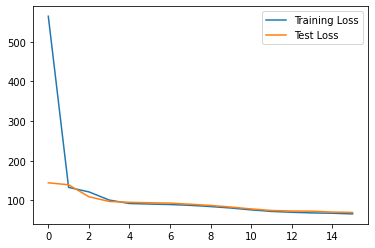

[17,     1] loss: 59.757
[17,     2] loss: 58.413
[17,     3] loss: 62.553
[17,     4] loss: 71.185
[17,     5] loss: 62.606
[17,     6] loss: 57.818
[17,     7] loss: 63.068
[17,     8] loss: 62.438
[17,     9] loss: 62.936
[17,    10] loss: 58.503
[17,    11] loss: 61.984
[17,    12] loss: 64.577
[17,    13] loss: 59.403
[17,    14] loss: 64.384
[17,    15] loss: 62.145
[17,    16] loss: 63.197
[17,    17] loss: 64.797
[17,    18] loss: 61.915
[17,    19] loss: 62.011
[17,    20] loss: 62.109
[17,    21] loss: 65.567
[17,    22] loss: 61.491
[17,    23] loss: 61.192
[17,    24] loss: 65.446
[17,    25] loss: 60.458
[17,    26] loss: 61.150
[17,    27] loss: 58.289
[17,    28] loss: 63.550
[17,    29] loss: 63.928
LOSS of the network on the train images after epoch 16 is 1806.8720970153809
Mean of the network on the train images after epoch 16 is 64.53114632197789
LOSS of the network on the test images: 824 %
Mean of the network on the train images after epoch 16 is 68.67765998840332


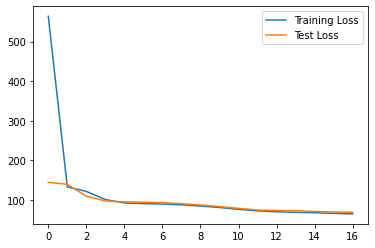

[18,     1] loss: 59.006
[18,     2] loss: 57.356
[18,     3] loss: 61.602
[18,     4] loss: 69.433
[18,     5] loss: 61.637
[18,     6] loss: 57.171
[18,     7] loss: 61.364
[18,     8] loss: 61.445
[18,     9] loss: 62.379
[18,    10] loss: 57.432
[18,    11] loss: 60.421
[18,    12] loss: 63.476
[18,    13] loss: 57.658
[18,    14] loss: 62.563
[18,    15] loss: 61.020
[18,    16] loss: 61.785
[18,    17] loss: 63.456
[18,    18] loss: 60.709
[18,    19] loss: 61.169
[18,    20] loss: 60.696
[18,    21] loss: 64.251
[18,    22] loss: 60.510
[18,    23] loss: 59.894
[18,    24] loss: 64.068
[18,    25] loss: 59.577
[18,    26] loss: 59.904
[18,    27] loss: 57.193
[18,    28] loss: 61.894
[18,    29] loss: 63.801
LOSS of the network on the train images after epoch 17 is 1772.8685264587402
Mean of the network on the train images after epoch 17 is 63.31673308781215
LOSS of the network on the test images: 815 %
Mean of the network on the train images after epoch 17 is 67.98044681549072


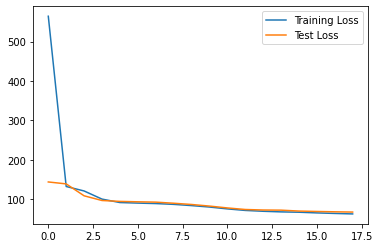

[19,     1] loss: 58.129
[19,     2] loss: 56.261
[19,     3] loss: 60.809
[19,     4] loss: 68.319
[19,     5] loss: 61.530
[19,     6] loss: 56.654
[19,     7] loss: 60.013
[19,     8] loss: 60.581
[19,     9] loss: 60.974
[19,    10] loss: 55.864
[19,    11] loss: 59.485
[19,    12] loss: 61.966
[19,    13] loss: 56.210
[19,    14] loss: 61.574
[19,    15] loss: 59.700
[19,    16] loss: 60.307
[19,    17] loss: 62.000
[19,    18] loss: 59.687
[19,    19] loss: 59.874
[19,    20] loss: 59.254
[19,    21] loss: 63.037
[19,    22] loss: 59.277
[19,    23] loss: 58.817
[19,    24] loss: 62.470
[19,    25] loss: 58.099
[19,    26] loss: 58.764
[19,    27] loss: 55.903
[19,    28] loss: 59.936
[19,    29] loss: 61.630
LOSS of the network on the train images after epoch 18 is 1737.1267547607422
Mean of the network on the train images after epoch 18 is 62.04024124145508
LOSS of the network on the test images: 795 %
Mean of the network on the train images after epoch 18 is 66.32981014251709


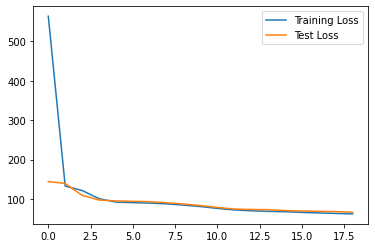

[20,     1] loss: 56.780
[20,     2] loss: 55.206
[20,     3] loss: 59.572
[20,     4] loss: 65.827
[20,     5] loss: 59.007
[20,     6] loss: 55.235
[20,     7] loss: 58.929
[20,     8] loss: 58.142
[20,     9] loss: 58.992
[20,    10] loss: 54.784
[20,    11] loss: 58.060
[20,    12] loss: 60.881
[20,    13] loss: 55.130
[20,    14] loss: 60.704
[20,    15] loss: 58.752
[20,    16] loss: 59.228
[20,    17] loss: 60.988
[20,    18] loss: 58.707
[20,    19] loss: 59.226
[20,    20] loss: 58.009
[20,    21] loss: 62.082
[20,    22] loss: 58.749
[20,    23] loss: 57.962
[20,    24] loss: 61.516
[20,    25] loss: 57.203
[20,    26] loss: 58.030
[20,    27] loss: 55.146
[20,    28] loss: 58.961
[20,    29] loss: 61.456
LOSS of the network on the train images after epoch 19 is 1703.265396118164
Mean of the network on the train images after epoch 19 is 60.830907004220144
LOSS of the network on the test images: 787 %
Mean of the network on the train images after epoch 19 is 65.6334851582845


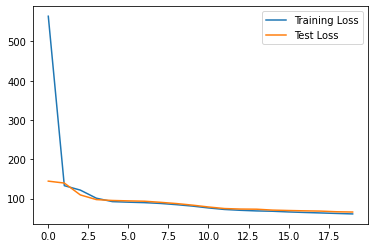

[21,     1] loss: 56.045
[21,     2] loss: 54.206
[21,     3] loss: 59.005
[21,     4] loss: 64.901
[21,     5] loss: 58.770
[21,     6] loss: 54.687
[21,     7] loss: 57.732
[21,     8] loss: 57.127
[21,     9] loss: 58.039
[21,    10] loss: 54.050
[21,    11] loss: 57.004
[21,    12] loss: 60.013
[21,    13] loss: 54.061
[21,    14] loss: 59.579
[21,    15] loss: 57.806
[21,    16] loss: 58.115
[21,    17] loss: 60.012
[21,    18] loss: 57.557
[21,    19] loss: 58.315
[21,    20] loss: 57.071
[21,    21] loss: 60.979
[21,    22] loss: 57.848
[21,    23] loss: 56.984
[21,    24] loss: 60.481
[21,    25] loss: 56.367
[21,    26] loss: 56.790
[21,    27] loss: 54.134
[21,    28] loss: 56.903
[21,    29] loss: 59.886
LOSS of the network on the train images after epoch 20 is 1674.4659385681152
Mean of the network on the train images after epoch 20 is 59.80235494886126
LOSS of the network on the test images: 772 %
Mean of the network on the train images after epoch 20 is 64.35800806681316


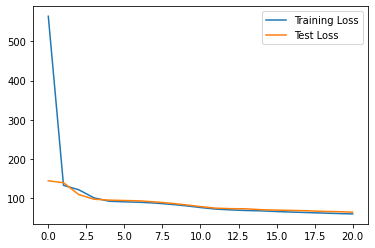

[22,     1] loss: 54.791
[22,     2] loss: 53.371
[22,     3] loss: 58.313
[22,     4] loss: 62.646
[22,     5] loss: 57.266
[22,     6] loss: 53.693
[22,     7] loss: 56.818
[22,     8] loss: 56.003
[22,     9] loss: 56.455
[22,    10] loss: 53.487
[22,    11] loss: 56.323
[22,    12] loss: 59.098
[22,    13] loss: 53.350
[22,    14] loss: 59.253
[22,    15] loss: 57.654
[22,    16] loss: 57.406
[22,    17] loss: 59.328
[22,    18] loss: 56.868
[22,    19] loss: 57.932
[22,    20] loss: 56.690
[22,    21] loss: 59.955
[22,    22] loss: 57.339
[22,    23] loss: 56.639
[22,    24] loss: 60.033
[22,    25] loss: 56.218
[22,    26] loss: 55.732
[22,    27] loss: 53.227
[22,    28] loss: 55.862
[22,    29] loss: 59.577
LOSS of the network on the train images after epoch 21 is 1651.3276901245117
Mean of the network on the train images after epoch 21 is 58.97598893301828
LOSS of the network on the test images: 768 %
Mean of the network on the train images after epoch 21 is 64.04310035705566


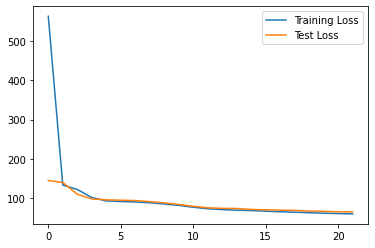

[23,     1] loss: 54.286
[23,     2] loss: 52.097
[23,     3] loss: 58.035
[23,     4] loss: 61.594
[23,     5] loss: 56.802
[23,     6] loss: 53.064
[23,     7] loss: 55.583
[23,     8] loss: 55.305
[23,     9] loss: 55.460
[23,    10] loss: 52.967
[23,    11] loss: 55.467
[23,    12] loss: 58.240
[23,    13] loss: 53.513
[23,    14] loss: 58.832
[23,    15] loss: 56.639
[23,    16] loss: 56.258
[23,    17] loss: 58.924
[23,    18] loss: 56.829
[23,    19] loss: 56.750
[23,    20] loss: 55.811
[23,    21] loss: 59.467
[23,    22] loss: 56.842
[23,    23] loss: 56.049
[23,    24] loss: 58.590
[23,    25] loss: 54.849
[23,    26] loss: 54.550
[23,    27] loss: 52.211
[23,    28] loss: 54.750
[23,    29] loss: 57.895
LOSS of the network on the train images after epoch 22 is 1627.6599502563477
Mean of the network on the train images after epoch 22 is 58.13071250915527
LOSS of the network on the test images: 758 %
Mean of the network on the train images after epoch 22 is 63.22987906138102


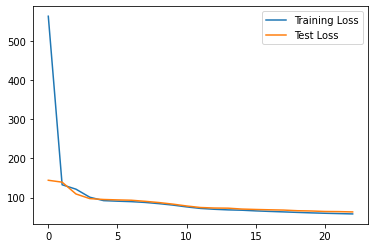

[24,     1] loss: 53.673
[24,     2] loss: 51.619
[24,     3] loss: 56.941
[24,     4] loss: 59.807
[24,     5] loss: 56.032
[24,     6] loss: 54.765
[24,     7] loss: 55.882
[24,     8] loss: 54.748
[24,     9] loss: 56.962
[24,    10] loss: 54.532
[24,    11] loss: 54.801
[24,    12] loss: 58.990
[24,    13] loss: 55.698
[24,    14] loss: 58.696
[24,    15] loss: 55.992
[24,    16] loss: 58.768
[24,    17] loss: 58.441
[24,    18] loss: 55.941
[24,    19] loss: 58.958
[24,    20] loss: 56.053
[24,    21] loss: 59.436
[24,    22] loss: 57.981
[24,    23] loss: 55.557
[24,    24] loss: 59.222
[24,    25] loss: 54.748
[24,    26] loss: 54.035
[24,    27] loss: 52.382
[24,    28] loss: 54.327
[24,    29] loss: 57.226
LOSS of the network on the train images after epoch 23 is 1632.2119140625
Mean of the network on the train images after epoch 23 is 58.293282645089285
LOSS of the network on the test images: 763 %
Mean of the network on the train images after epoch 23 is 63.60854721069336


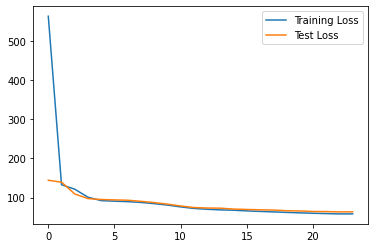

[25,     1] loss: 54.115
[25,     2] loss: 50.612
[25,     3] loss: 56.758
[25,     4] loss: 61.378
[25,     5] loss: 54.477
[25,     6] loss: 52.372
[25,     7] loss: 54.883
[25,     8] loss: 53.601
[25,     9] loss: 54.382
[25,    10] loss: 51.821
[25,    11] loss: 53.948
[25,    12] loss: 56.392
[25,    13] loss: 50.934
[25,    14] loss: 56.716
[25,    15] loss: 54.820
[25,    16] loss: 54.885
[25,    17] loss: 56.520
[25,    18] loss: 54.675
[25,    19] loss: 54.829
[25,    20] loss: 54.262
[25,    21] loss: 57.730
[25,    22] loss: 54.955
[25,    23] loss: 54.289
[25,    24] loss: 57.284
[25,    25] loss: 52.790
[25,    26] loss: 53.179
[25,    27] loss: 50.327
[25,    28] loss: 52.741
[25,    29] loss: 56.494
LOSS of the network on the train images after epoch 24 is 1582.1707382202148
Mean of the network on the train images after epoch 24 is 56.5060977935791
LOSS of the network on the test images: 743 %
Mean of the network on the train images after epoch 24 is 61.987308184305824


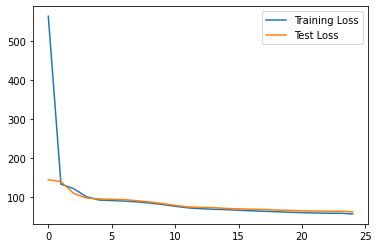

[26,     1] loss: 52.367
[26,     2] loss: 49.291
[26,     3] loss: 55.400
[26,     4] loss: 58.183
[26,     5] loss: 53.402
[26,     6] loss: 51.114
[26,     7] loss: 53.061
[26,     8] loss: 52.692
[26,     9] loss: 52.988
[26,    10] loss: 50.755
[26,    11] loss: 53.044
[26,    12] loss: 55.316
[26,    13] loss: 50.219
[26,    14] loss: 55.816
[26,    15] loss: 53.978
[26,    16] loss: 54.066
[26,    17] loss: 55.678
[26,    18] loss: 53.689
[26,    19] loss: 54.005
[26,    20] loss: 53.483
[26,    21] loss: 56.787
[26,    22] loss: 54.182
[26,    23] loss: 53.390
[26,    24] loss: 56.458
[26,    25] loss: 51.960
[26,    26] loss: 52.277
[26,    27] loss: 49.465
[26,    28] loss: 51.883
[26,    29] loss: 55.631
LOSS of the network on the train images after epoch 25 is 1550.5814971923828
Mean of the network on the train images after epoch 25 is 55.37791061401367
LOSS of the network on the test images: 736 %
Mean of the network on the train images after epoch 25 is 61.38017336527506


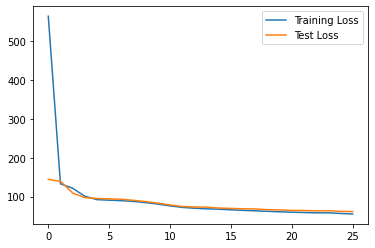

[27,     1] loss: 51.618
[27,     2] loss: 48.453
[27,     3] loss: 54.638
[27,     4] loss: 57.278
[27,     5] loss: 52.866
[27,     6] loss: 50.104
[27,     7] loss: 52.237
[27,     8] loss: 52.214
[27,     9] loss: 52.166
[27,    10] loss: 50.201
[27,    11] loss: 52.522
[27,    12] loss: 54.816
[27,    13] loss: 49.655
[27,    14] loss: 55.175
[27,    15] loss: 53.675
[27,    16] loss: 53.441
[27,    17] loss: 55.011
[27,    18] loss: 53.193
[27,    19] loss: 53.368
[27,    20] loss: 52.899
[27,    21] loss: 56.055
[27,    22] loss: 53.578
[27,    23] loss: 52.714
[27,    24] loss: 55.828
[27,    25] loss: 51.304
[27,    26] loss: 51.614
[27,    27] loss: 48.872
[27,    28] loss: 51.229
[27,    29] loss: 54.972
LOSS of the network on the train images after epoch 26 is 1531.6942672729492
Mean of the network on the train images after epoch 26 is 54.70336668831961
LOSS of the network on the test images: 729 %
Mean of the network on the train images after epoch 26 is 60.7658478418986


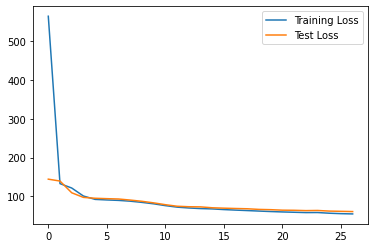

[28,     1] loss: 50.802
[28,     2] loss: 47.978
[28,     3] loss: 53.901
[28,     4] loss: 56.259
[28,     5] loss: 52.322
[28,     6] loss: 49.448
[28,     7] loss: 51.394
[28,     8] loss: 51.719
[28,     9] loss: 51.818
[28,    10] loss: 49.728
[28,    11] loss: 51.948
[28,    12] loss: 54.536
[28,    13] loss: 49.563
[28,    14] loss: 54.480
[28,    15] loss: 53.439
[28,    16] loss: 53.181
[28,    17] loss: 54.351
[28,    18] loss: 52.832
[28,    19] loss: 53.013
[28,    20] loss: 52.503
[28,    21] loss: 55.479
[28,    22] loss: 53.313
[28,    23] loss: 52.120
[28,    24] loss: 55.370
[28,    25] loss: 50.784
[28,    26] loss: 51.052
[28,    27] loss: 48.294
[28,    28] loss: 51.027
[28,    29] loss: 54.424
LOSS of the network on the train images after epoch 27 is 1517.0779418945312
Mean of the network on the train images after epoch 27 is 54.18135506766183
LOSS of the network on the test images: 723 %
Mean of the network on the train images after epoch 27 is 60.28707981109619


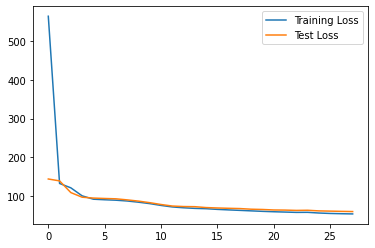

[29,     1] loss: 50.154
[29,     2] loss: 47.504
[29,     3] loss: 53.525
[29,     4] loss: 55.439
[29,     5] loss: 51.748
[29,     6] loss: 48.991
[29,     7] loss: 50.841
[29,     8] loss: 51.169
[29,     9] loss: 51.389
[29,    10] loss: 49.501
[29,    11] loss: 51.175
[29,    12] loss: 54.299
[29,    13] loss: 49.133
[29,    14] loss: 53.645
[29,    15] loss: 52.820
[29,    16] loss: 52.525
[29,    17] loss: 53.772
[29,    18] loss: 52.098
[29,    19] loss: 52.730
[29,    20] loss: 51.821
[29,    21] loss: 54.995
[29,    22] loss: 52.418
[29,    23] loss: 51.712
[29,    24] loss: 54.639
[29,    25] loss: 50.394
[29,    26] loss: 50.329
[29,    27] loss: 48.263
[29,    28] loss: 50.449
[29,    29] loss: 53.855
LOSS of the network on the train images after epoch 28 is 1501.3333129882812
Mean of the network on the train images after epoch 28 is 53.61904689243862
LOSS of the network on the test images: 720 %
Mean of the network on the train images after epoch 28 is 60.079163551330566

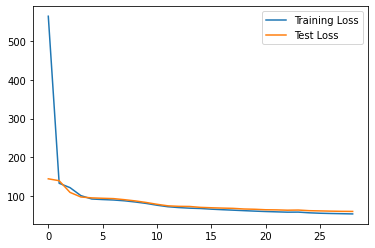

[30,     1] loss: 49.736
[30,     2] loss: 47.109
[30,     3] loss: 53.002
[30,     4] loss: 54.569
[30,     5] loss: 51.412
[30,     6] loss: 48.298
[30,     7] loss: 50.464
[30,     8] loss: 50.353
[30,     9] loss: 50.912
[30,    10] loss: 48.814
[30,    11] loss: 50.730
[30,    12] loss: 53.395
[30,    13] loss: 48.473
[30,    14] loss: 52.980
[30,    15] loss: 52.079
[30,    16] loss: 51.759
[30,    17] loss: 53.139
[30,    18] loss: 51.674
[30,    19] loss: 51.902
[30,    20] loss: 51.467
[30,    21] loss: 54.281
[30,    22] loss: 51.796
[30,    23] loss: 51.116
[30,    24] loss: 54.205
[30,    25] loss: 49.744
[30,    26] loss: 49.849
[30,    27] loss: 47.820
[30,    28] loss: 49.856
[30,    29] loss: 53.101
LOSS of the network on the train images after epoch 29 is 1484.0338516235352
Mean of the network on the train images after epoch 29 is 53.00120898655483
LOSS of the network on the test images: 718 %
Mean of the network on the train images after epoch 29 is 59.91582743326823


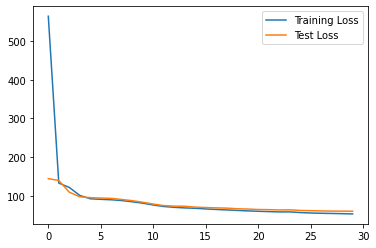

Finished Training


In [33]:
train_loss_graph = []
test_loss_graph = []

indian_loss_graph = []
western_loss_graph = []

for epoch in range(n_epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    total_Loss = 0.0
    correct = 0
    total = 0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels, fileNames = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        total_Loss += loss.item()

        if i % print_every == 0:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / print_every))
            running_loss = 0.0
    
    print('LOSS of the network on the train images after epoch {} is {}'.format(epoch, total_Loss) )
    if reduction_loss == "mean":
      total_Loss = total_Loss/i
      print('Mean of the network on the train images after epoch {} is {}'.format(epoch, total_Loss) )
    
    train_loss_graph.append(total_Loss)
    correct = 0
    total = 0
    running_loss = 0.0
    total_Loss = 0.0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for j, data in enumerate(testloader,0):
            inputs, labels, fileNames = data
            inputs, labels = inputs.to(device), labels.to(device)
            # calculate outputs by running images through the network
            outputs = net(inputs)
            loss = criterion(outputs, inputs)
            running_loss += loss.item()
            total_Loss += loss.item()

    print('LOSS of the network on the test images: %d %%' % (total_Loss))
    if reduction_loss == "mean":
      total_Loss = total_Loss/j
      print('Mean of the network on the train images after epoch {} is {}'.format(epoch, total_Loss) )
      
    
    test_loss_graph.append(total_Loss)
    visualize(train_loss_graph, test_loss_graph)

print('Finished Training')

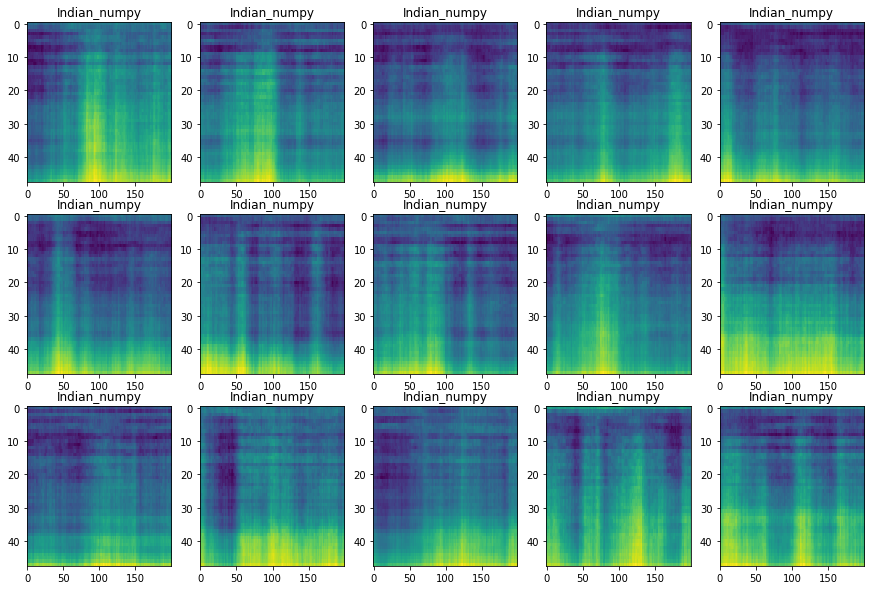

In [34]:
# get some random training images
dataiter = iter(testloader)
images, labels, fileNames = dataiter.next()
arthopod_types = {0: 'Indian_numpy', 1: 'Western_numpy', 2: 'country', 3: 'disco', 4: 'hiphop', 5: 'jazz', 6: 'metal', 7: 'pop', 8: 'reggae', 9: 'rock'}
# Viewing data examples used for training
fig, axis = plt.subplots(3, 5, figsize=(15, 10))
for i, ax in enumerate(axis.flat):
    with torch.no_grad():
        image, label = images[i], labels[i]
        image, labels = image.to(device), labels.to(device)
        output_img = net(image.unsqueeze(dim=0))
        ax.imshow(mel_display(output_img.detach().cpu()), interpolation='nearest', aspect='auto') # add image
        ax.set(title = f"{arthopod_types[label.item()]}") # add label

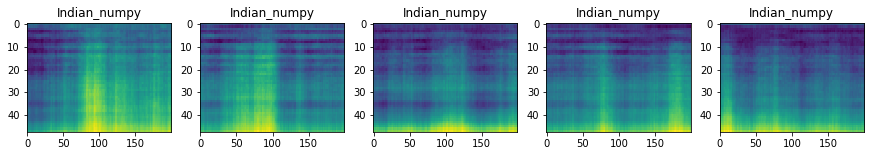

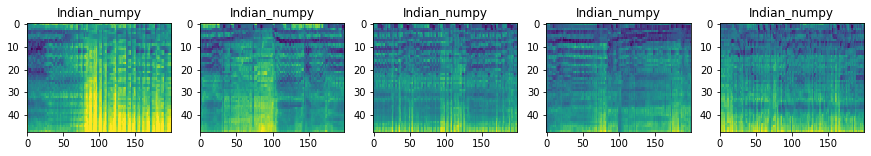

In [35]:
# get some random training images
outputs=[]
dataiter = iter(testloader)
images, labels, fileNames = dataiter.next()
arthopod_types = {0: 'Indian_numpy', 1: 'Western_numpy', 2: 'country', 3: 'disco', 4: 'hiphop', 5: 'jazz', 6: 'metal', 7: 'pop', 8: 'reggae', 9: 'rock'}
# Viewing data examples used for training
fig, axis = plt.subplots(1, 5, figsize=(15, 2))
for i, ax in enumerate(axis.flat):
    with torch.no_grad():
        image, label = images[i], labels[i]
        image, labels = image.to(device), labels.to(device)
        output_img = net(image.unsqueeze(dim=0))
        ax.imshow(mel_display(output_img.detach().cpu()), interpolation='nearest', aspect='auto') # add image
        outputs.append((mel_display(image.detach().cpu().unsqueeze(dim=0)),arthopod_types[label.item()] ))
        ax.set(title = f"{arthopod_types[label.item()]}") # add label

fig, axis = plt.subplots(1, 5, figsize=(15, 2))
for ax , (image, label) in zip(axis.flat, outputs):
    ax.imshow(image, interpolation='nearest', aspect='auto') # add image
    ax.set(title = f"{label}") # add label
    
        

In [38]:
torch.save(net.state_dict(), os.path.join(BASE_PATH, "final_model.pt"))

Start evaluation - Test model

In [39]:
model = RecurrentAutoencoder(seq_len, input_bins, AE_encoded_dim, device=device)
model.load_state_dict(torch.load(os.path.join(BASE_PATH, "final_model.pt"), map_location=device))

<All keys matched successfully>

Strict data separation

In [40]:
for class_ in classes:
  dir = os.path.join(BASE_PATH, "Activations_64", "test", str(class_))
  #print("removing ", dir)
  for f in os.listdir(dir):
    #print("removing ", os.path.join(dir, f))
    os.remove(os.path.join(dir, f))

for class_ in classes:
  dir = os.path.join(BASE_PATH, "Activations_128", "test", str(class_))
  for f in os.listdir(dir):
    os.remove(os.path.join(dir, f))

for class_ in classes:
  dir = os.path.join(BASE_PATH, "reconstructions", "test", str(class_))
  for f in os.listdir(dir):
    os.remove(os.path.join(dir, f))

for class_ in classes:
  dir = os.path.join(BASE_PATH, "originals", "test", str(class_))
  for f in os.listdir(dir):
    os.remove(os.path.join(dir, f))


for class_ in classes:
  dir = os.path.join(BASE_PATH, "Activations_64", "training", str(class_))
  for f in os.listdir(dir):
    os.remove(os.path.join(dir, f))

for class_ in classes:
  dir = os.path.join(BASE_PATH, "Activations_128", "training", str(class_))
  for f in os.listdir(dir):
    os.remove(os.path.join(dir, f))

for class_ in classes:
  dir = os.path.join(BASE_PATH, "reconstructions", "training", str(class_))
  for f in os.listdir(dir):
    os.remove(os.path.join(dir, f))

for class_ in classes:
  dir = os.path.join(BASE_PATH, "originals", "training", str(class_))
  for f in os.listdir(dir):
    os.remove(os.path.join(dir, f))


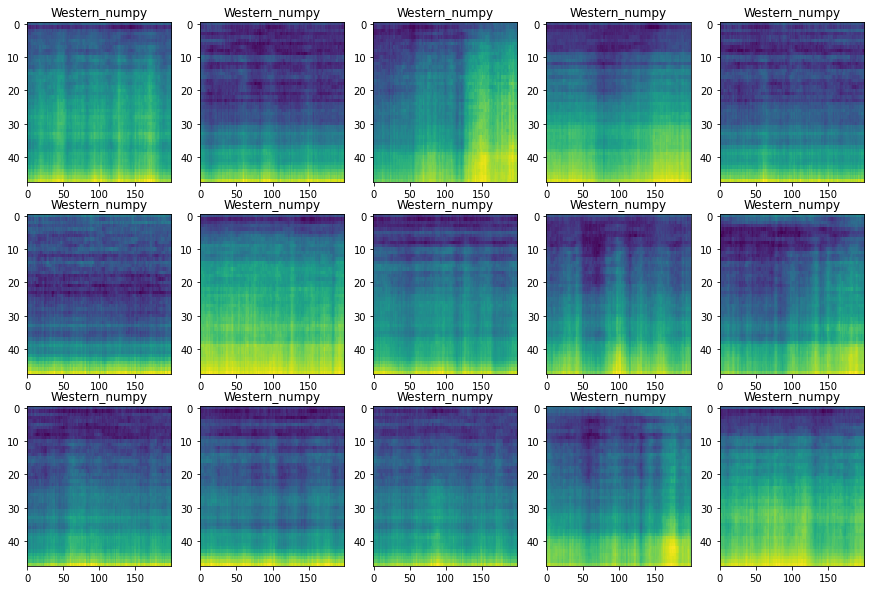

In [41]:
# get some random training images
dataiter = iter(trainloader_combined)
images, labels, fileNames = dataiter.next()
arthopod_types = {0: 'Indian_numpy', 1: 'Western_numpy', 2: 'country', 3: 'disco', 4: 'hiphop', 5: 'jazz', 6: 'metal', 7: 'pop', 8: 'reggae', 9: 'rock'}
# Viewing data examples used for training
fig, axis = plt.subplots(3, 5, figsize=(15, 10))
for i, ax in enumerate(axis.flat):
    with torch.no_grad():
        image, label = images[i], labels[i]
        image, labels = image.to(device), labels.to(device)
        output_img = net(image.unsqueeze(dim=0))
        ax.imshow(mel_display(output_img.detach().cpu()), interpolation='nearest', aspect='auto') # add image
        ax.set(title = f"{arthopod_types[label.item()]}") # add label

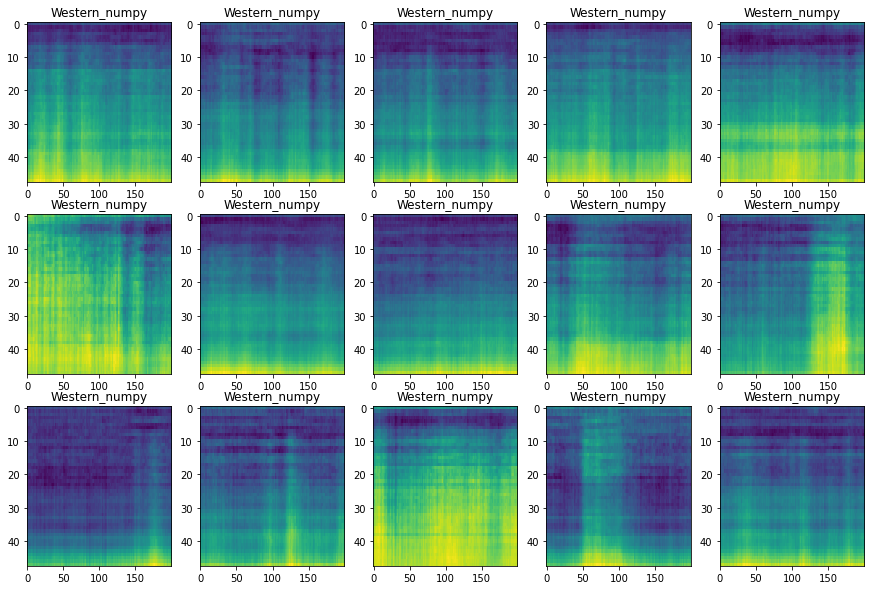

In [42]:
# get some random training images
dataiter = iter(testloader_combined)
images, labels, fileNames = dataiter.next()
arthopod_types = {0: 'Indian_numpy', 1: 'Western_numpy', 2: 'country', 3: 'disco', 4: 'hiphop', 5: 'jazz', 6: 'metal', 7: 'pop', 8: 'reggae', 9: 'rock'}
# Viewing data examples used for training
fig, axis = plt.subplots(3, 5, figsize=(15, 10))
for i, ax in enumerate(axis.flat):
    with torch.no_grad():
        image, label = images[i], labels[i]
        image, labels = image.to(device), labels.to(device)
        output_img = net(image.unsqueeze(dim=0))
        ax.imshow(mel_display(output_img.detach().cpu()), interpolation='nearest', aspect='auto') # add image
        ax.set(title = f"{arthopod_types[label.item()]}") # add label

In [43]:
id_test = 0
with torch.no_grad():
    for data_test in testloader_combined:
        inputs, labels, fileNames = data_test
        inputs, labels = inputs.to(device), labels.to(device)
        output_l2, output_l1 = model.encoder(inputs)
        output = model(inputs)
        output_l2 = output_l2.detach().cpu().numpy()
        output_l1 = output_l1.detach().cpu().numpy()
        output = output.detach().cpu().numpy()
        labels = labels.detach().cpu().numpy()
        inputs = inputs.detach().cpu().numpy()
        
        for  orr48, arr64, arr128, arr48, label, fileName in zip(inputs, output_l2, output_l1, output, labels, fileNames):
          print(os.path.join(BASE_PATH, "Activations_64", "test", str(classes[label]), str(fileName)))
          np.save(os.path.join(BASE_PATH, "Activations_64", "test",str(classes[label]), str(fileName)),np.transpose(arr64, (1,0)))
          np.save(os.path.join(BASE_PATH, "Activations_128", "test",classes[label] ,  str(fileName)), np.transpose(arr128, (1,0)))
          np.save(os.path.join(BASE_PATH, "reconstructions", "test",classes[label] ,  str(fileName)), np.transpose(arr48, (1,0)))
          np.save(os.path.join(BASE_PATH, "originals", "test",classes[label] ,  str(fileName)), np.transpose(orr48, (1,0)))
          id_test = id_test + 1




/content/gdrive/My Drive/vajra/AE_HYBRID_GURBANI/Activations_64/test/Indian_numpy/indianDilSeRe_mel_0.npy
/content/gdrive/My Drive/vajra/AE_HYBRID_GURBANI/Activations_64/test/Indian_numpy/indianYehLadkaHaiAllah_mel_0.npy
/content/gdrive/My Drive/vajra/AE_HYBRID_GURBANI/Activations_64/test/Indian_numpy/indianHarjaayi_mel_1.npy
/content/gdrive/My Drive/vajra/AE_HYBRID_GURBANI/Activations_64/test/Indian_numpy/indianThalirila,Pt.1_mel_1.npy
/content/gdrive/My Drive/vajra/AE_HYBRID_GURBANI/Activations_64/test/Indian_numpy/indianHumBalakNaadaanHumeDoGyanShardeMaaSaraswatiBhajan_mel_0.npy
/content/gdrive/My Drive/vajra/AE_HYBRID_GURBANI/Activations_64/test/Indian_numpy/indianOzhukiyozhuki_mel_0.npy
/content/gdrive/My Drive/vajra/AE_HYBRID_GURBANI/Activations_64/test/Indian_numpy/indianMillLoNa_mel_1.npy
/content/gdrive/My Drive/vajra/AE_HYBRID_GURBANI/Activations_64/test/Indian_numpy/indianReason_mel_0.npy
/content/gdrive/My Drive/vajra/AE_HYBRID_GURBANI/Activations_64/test/Indian_numpy/india

In [44]:
id_train = 0
with torch.no_grad():
    for data in trainloader_combined:
        inputs, labels, fileNames = data
        inputs, labels = inputs.to(device), labels.to(device)
        output_l2, output_l1 = model.encoder(inputs)
        output = model(inputs)
        output_l2 = output_l2.detach().cpu().numpy()
        output_l1 = output_l1.detach().cpu().numpy()
        output = output.detach().cpu().numpy()
        labels = labels.detach().cpu().numpy()
        inputs = inputs.detach().cpu().numpy()
        
        for  orr48, arr64, arr128, arr48, label, fileName in zip(inputs, output_l2, output_l1, output, labels, fileNames):
          print(os.path.join(BASE_PATH, "Activations_64", "training", str(classes[label]), str(fileName)))
          np.save(os.path.join(BASE_PATH, "Activations_64", "training",str(classes[label]), str(fileName)),np.transpose(arr64, (1,0)))
          np.save(os.path.join(BASE_PATH, "Activations_128", "training",classes[label] ,  str(fileName)), np.transpose(arr128, (1,0)))
          np.save(os.path.join(BASE_PATH, "reconstructions", "training",classes[label] ,  str(fileName)), np.transpose(arr48, (1,0)))
          np.save(os.path.join(BASE_PATH, "originals", "training",classes[label] ,  str(fileName)), np.transpose(orr48, (1,0)))
          id_train = id_train + 1

Streaming output truncated to the last 5000 lines.
/content/gdrive/My Drive/vajra/AE_HYBRID_GURBANI/Activations_64/training/Western_numpy/western_134931_mel_0.npy
/content/gdrive/My Drive/vajra/AE_HYBRID_GURBANI/Activations_64/training/Western_numpy/western_039900_mel_0.npy
/content/gdrive/My Drive/vajra/AE_HYBRID_GURBANI/Activations_64/training/Western_numpy/western_038353_mel_1.npy
/content/gdrive/My Drive/vajra/AE_HYBRID_GURBANI/Activations_64/training/Western_numpy/western_093917_mel_0.npy
/content/gdrive/My Drive/vajra/AE_HYBRID_GURBANI/Activations_64/training/Western_numpy/western_140609_mel_1.npy
/content/gdrive/My Drive/vajra/AE_HYBRID_GURBANI/Activations_64/training/Western_numpy/western_003598_mel_1.npy
/content/gdrive/My Drive/vajra/AE_HYBRID_GURBANI/Activations_64/training/Western_numpy/western_140260_mel_0.npy
/content/gdrive/My Drive/vajra/AE_HYBRID_GURBANI/Activations_64/training/Western_numpy/western_066636_mel_1.npy
/content/gdrive/My Drive/vajra/AE_HYBRID_GURBANI/Acti